In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from oasis.functions import deconvolve
from scipy.stats import pearsonr
from statistics import mean

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

import utils.sulfur.constant as const

from utils.cofiring_graph_generator import CofiringGraphGenerator

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

In [3]:
index = const.ANIMAL_NAMES
columns_df = pd.DataFrame()
contexts = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
features = ['clustering coefficient', 'shortest path length', 'co-firing strength', 'total weight', 'total number of edges', 'assortativity']
context_columns = []
for context_name in contexts:
    context_columns += [context_name] * len(features)
columns_df.loc[:, 'context'] = context_columns
columns_df.loc[:, 'feature'] = features * len(contexts)
columns = pd.MultiIndex.from_frame(columns_df)

df = pd.DataFrame(0.0, index=index, columns=columns)

In [4]:
def average_path_length(graph, weight='length'):
    def path_lengths(graph, node, weight='length'):
        lengths = []
        for target in graph:
            if not nx.has_path(graph, node, target) or node == target:
                continue
                
            lengths.append(nx.dijkstra_path_length(graph, node, target, weight=weight))
        
        return lengths
    
    all_lengths = []
    for node in graph:
        all_lengths.extend(path_lengths(graph, node, weight))
    
    return mean(all_lengths)

def calc_features(animal_name, context_name, graph, df):
    df.loc[animal_name, (context_name, 'clustering coefficient')] += nx.average_clustering(graph, weight='weight')
    df.loc[animal_name, (context_name, 'shortest path length')] += average_path_length(graph)
    
    adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(graph).todense())
    df.loc[animal_name, (context_name, 'co-firing strength')] += adjacency_matrix.sum().mean()
    df.loc[animal_name, (context_name, 'assortativity')] += nx.degree_pearson_correlation_coefficient(graph, weight='weight')
    df.loc[animal_name, (context_name, 'total weight')] += sum(weight for _, _, weight in graph.edges.data("weight"))
    df.loc[animal_name, (context_name, 'total number of edges')] += len(graph.edges.data("weight"))
    
def average_features(animal_name, context_name, df, size):
    df.loc[animal_name, (context_name, 'clustering coefficient')] /= size
    df.loc[animal_name, (context_name, 'shortest path length')] /= size
    df.loc[animal_name, (context_name, 'co-firing strength')] /= size
    df.loc[animal_name, (context_name, 'assortativity')] /= size
    df.loc[animal_name, (context_name, 'total weight')] /= size
    df.loc[animal_name, (context_name, 'total number of edges')] /= size
    
def all_context_graph(generator, animal_name, context_name, df):
    iter_size = 100
    frame_range = 20
    
    for i in range(iter_size):
        index = i * frame_range
        graph = generator.run(index, index + frame_range)
        calc_features(animal_name, context_name, graph, df)
    average_features(animal_name, context_name, df, iter_size)

animal_name: ID181106CreA
##### context: A1post
##### context: A4post
animal_name: ID181106CreB
##### context: A1post
##### context: A4post
animal_name: ID181106CreC
##### context: A1post
##### context: A4post
animal_name: ID181106CreG
##### context: A1post
##### context: A4post
animal_name: ID181106CreH
##### context: A1post
##### context: A4post
animal_name: ID181106CreI
##### context: A1post
##### context: A4post
animal_name: ID181106CreK
##### context: A1post
##### context: A4post
animal_name: ID181106CreL
##### context: A1post
##### context: A4post
animal_name: ID181106CreN
##### context: A1post
##### context: A4post
animal_name: ID181106CreQ
##### context: A1post
##### context: A4post
CPU times: user 3min 8s, sys: 3.32 s, total: 3min 11s
Wall time: 1min 2s


context                        A1_1                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.081148             6.687998           1.083529   
ID181106CreB               0.101208             6.034428           0.723598   
ID181106CreC               0.071290             7.860090           0.540511   
ID181106CreG               0.080016             6.393310           0.947765   
ID181106CreH               0.091964             5.541180           1.784136   
ID181106CreI               0.068504             6.249616           1.141957   
ID181106CreK               0.091227             6.956096           0.675750   
ID181106CreL               0.046988             7.038849           0.435934   
ID181106CreN               0.148668             7.192557           1.327593   
ID181106CreQ               0.045728             7.360933           0.477852   

context                                                        \
feature      total weight total number of edges assortativity   
ID181106CreA    30.880588                  88.0      0.273445   
ID181106CreB    14.110151                  37.0      0.283269   
ID181106CreC    10.810225                  33.0     -0.057564   
ID181106CreG    24.641888                  72.0      0.145330   
ID181106CreH   108.832323                 279.0      0.260996   
ID181106CreI    72.514241                 193.0      0.140228   
ID181106CreK    12.839247                  37.0     -0.110071   
ID181106CreL     7.192904                  18.0      0.042796   
ID181106CreN    21.905282                  55.0      0.221514   
ID181106CreQ     6.928861                  19.0     -0.055411   

context                        A1_2                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.069985            10.018992           0.637891   
ID181106CreB               0.140717             6.073838           0.783135   
ID181106CreC               0.064553             7.978646           0.517363   
ID181106CreG               0.099832             6.451607           1.019750   
ID181106CreH               0.098781             5.927260           1.933712   
ID181106CreI               0.063185             5.974347           0.846984   
ID181106CreK               0.125450             6.817396           1.193888   
ID181106CreL               0.131842             5.437658           0.666934   
ID181106CreN               0.181244             7.562240           1.548422   
ID181106CreQ               0.121778             9.493309           0.759800   

context                    ...               A4_2               \
feature      total weight  ... co-firing strength total weight   
ID181106CreA    18.179884  ...           0.243455     6.938464   
ID181106CreB    15.271136  ...           0.671382    13.091945   
ID181106CreC    10.347250  ...           1.695284    33.905684   
ID181106CreG    26.513488  ...           0.629703    16.372286   
ID181106CreH   117.956448  ...           1.384054    84.427321   
ID181106CreI    53.783485  ...           1.395939    88.642105   
ID181106CreK    22.683866  ...           1.504030    28.576577   
ID181106CreL    11.004406  ...           0.265373     4.378658   
ID181106CreN    25.548959  ...           0.370306     6.110041   
ID181106CreQ    11.017099  ...           0.608893     8.828948   

context                                                            A4_3  \
feature      total number of edges assortativity clustering coefficient   
ID181106CreA                  15.0      0.535979               0.069593   
ID181106CreB                  30.0      0.120120               0.102119   
ID181106CreC                 101.0      0.256365               0.157822   
ID181106CreG                  51.0      0.248709               0.058428   
ID181106CreH                 203.0      0.228999               0.085002   
ID1

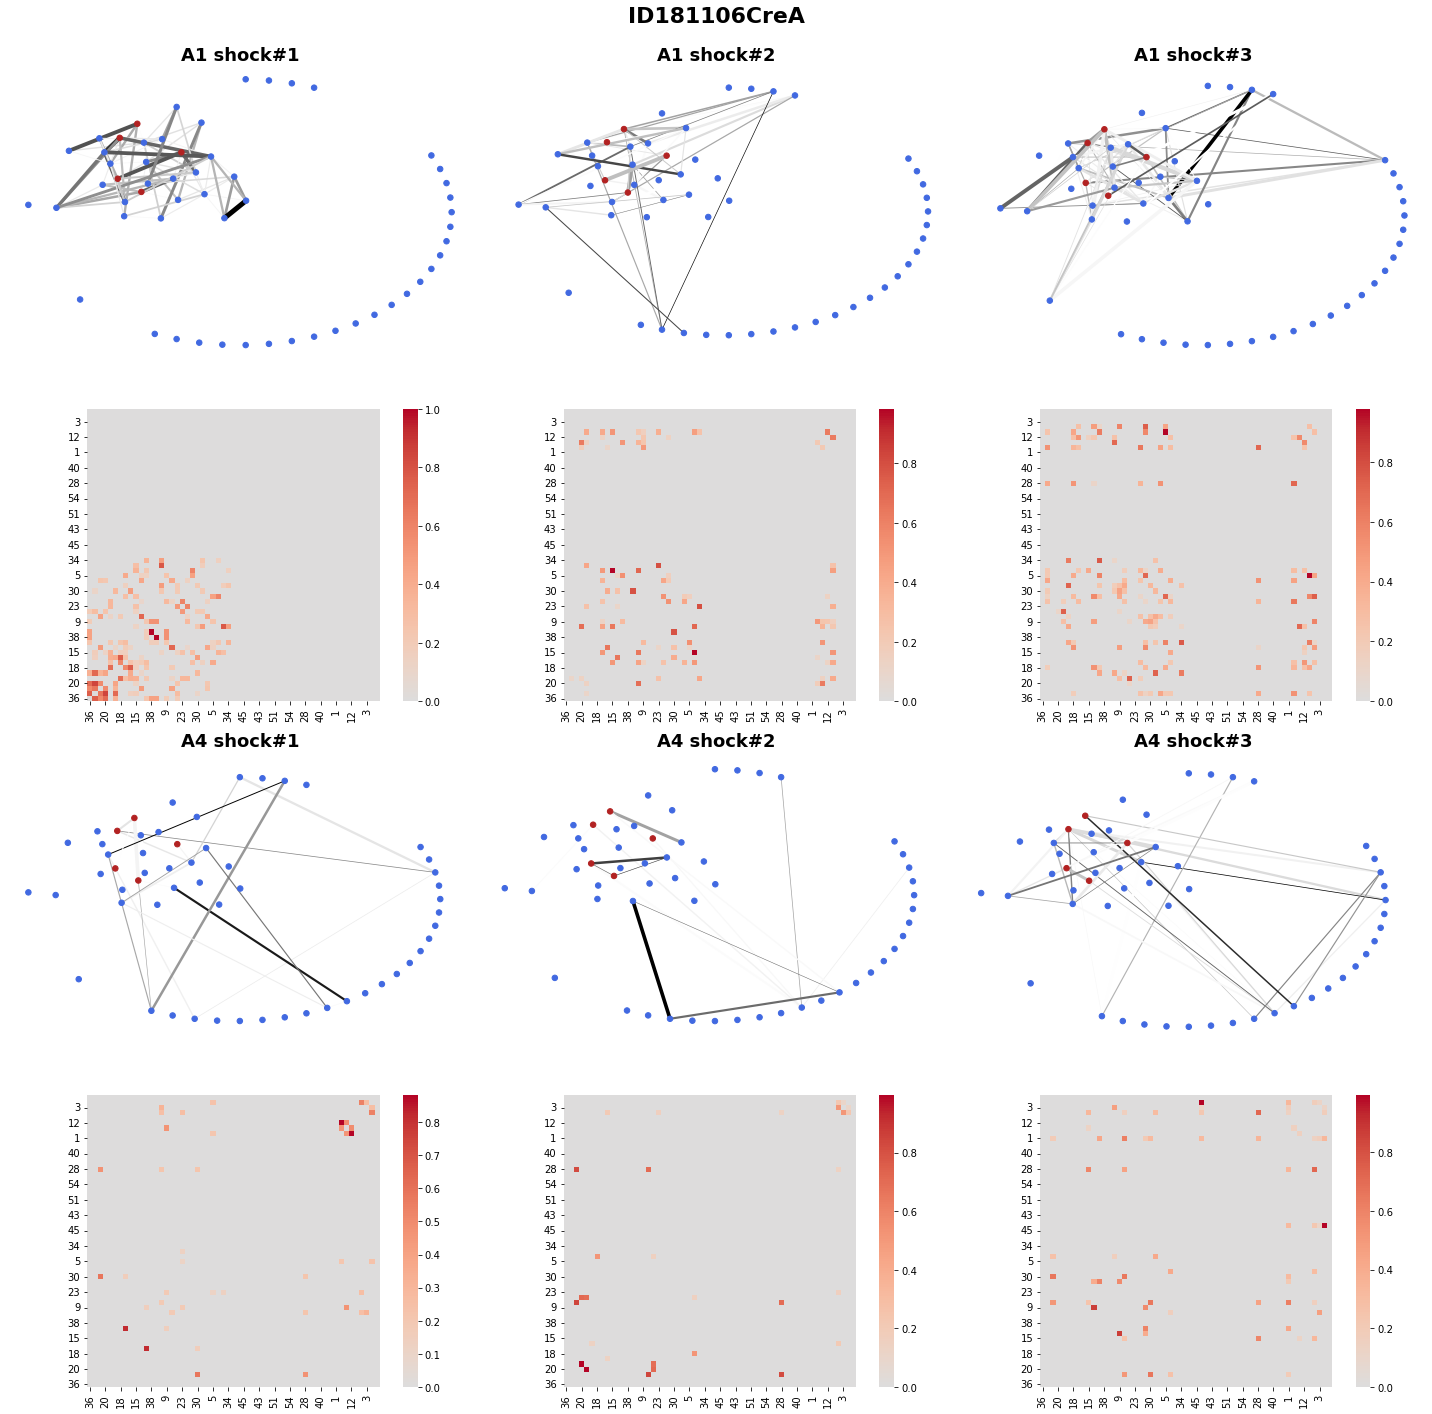

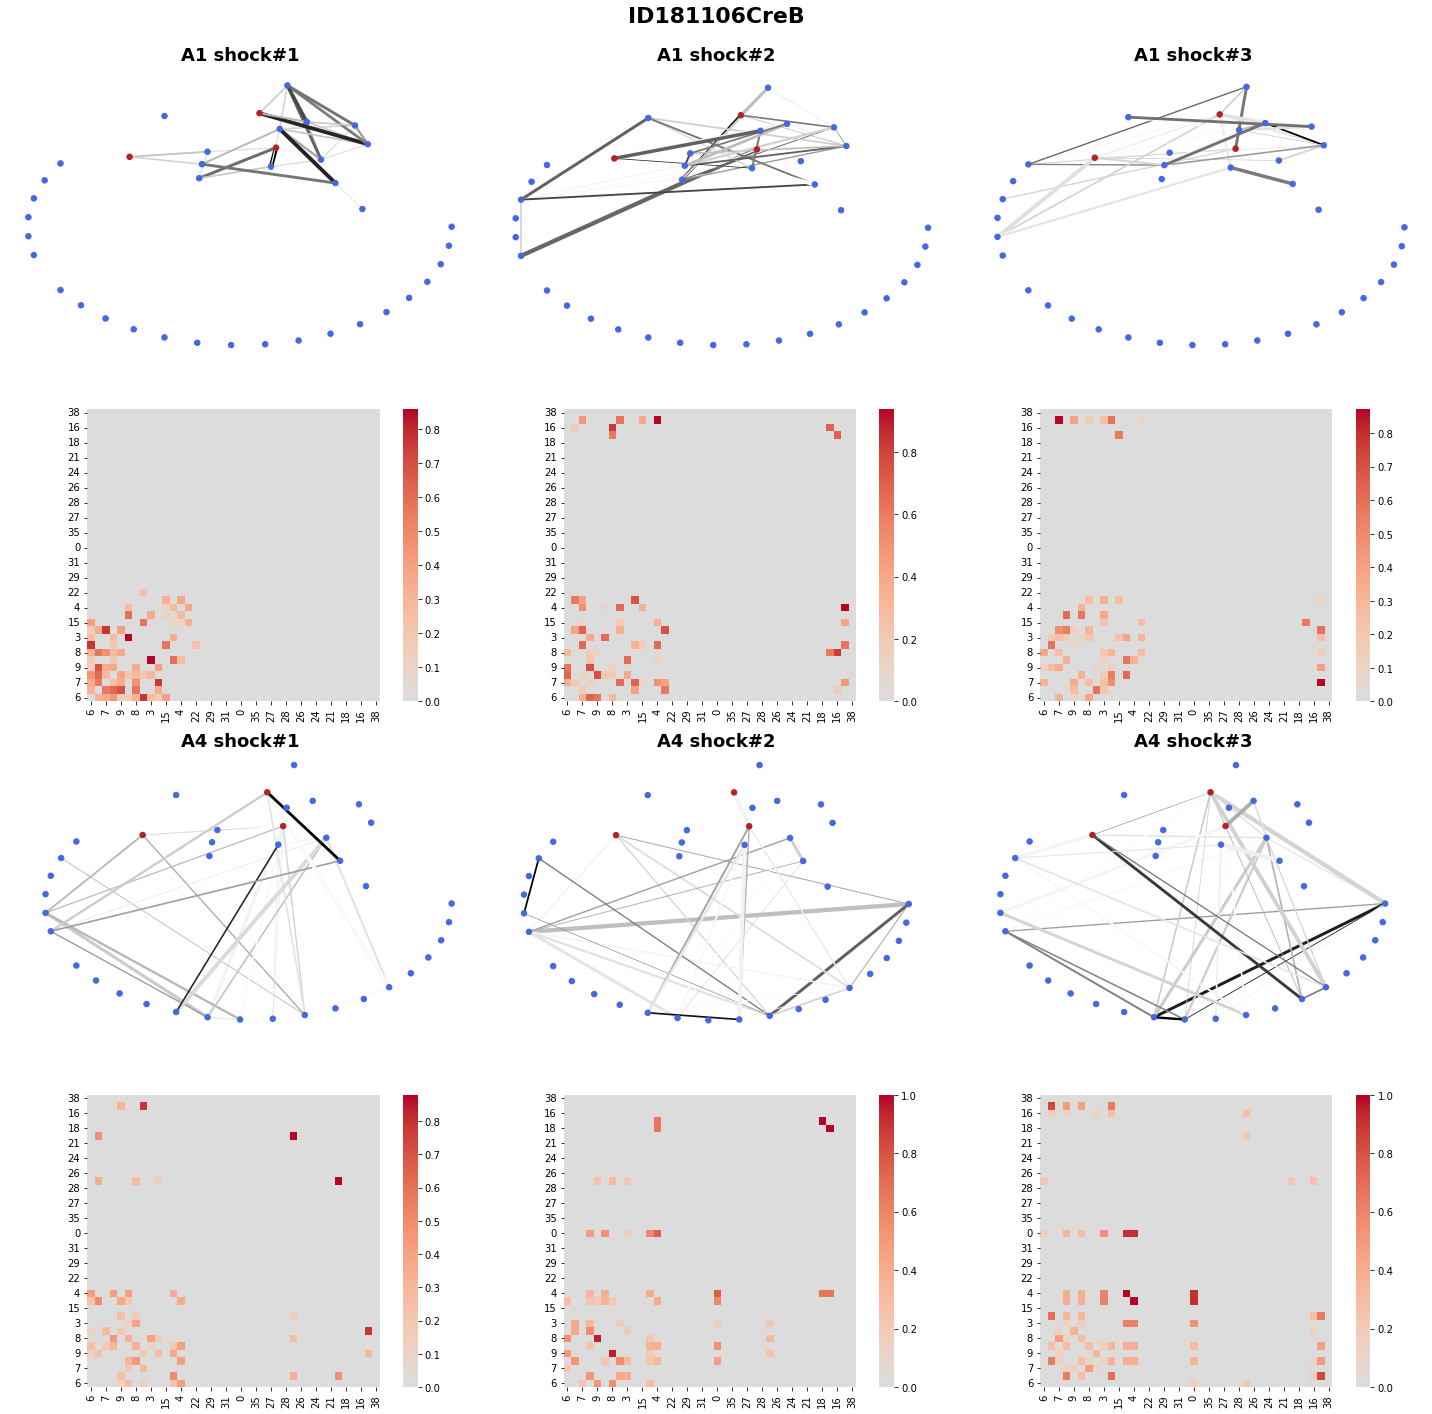

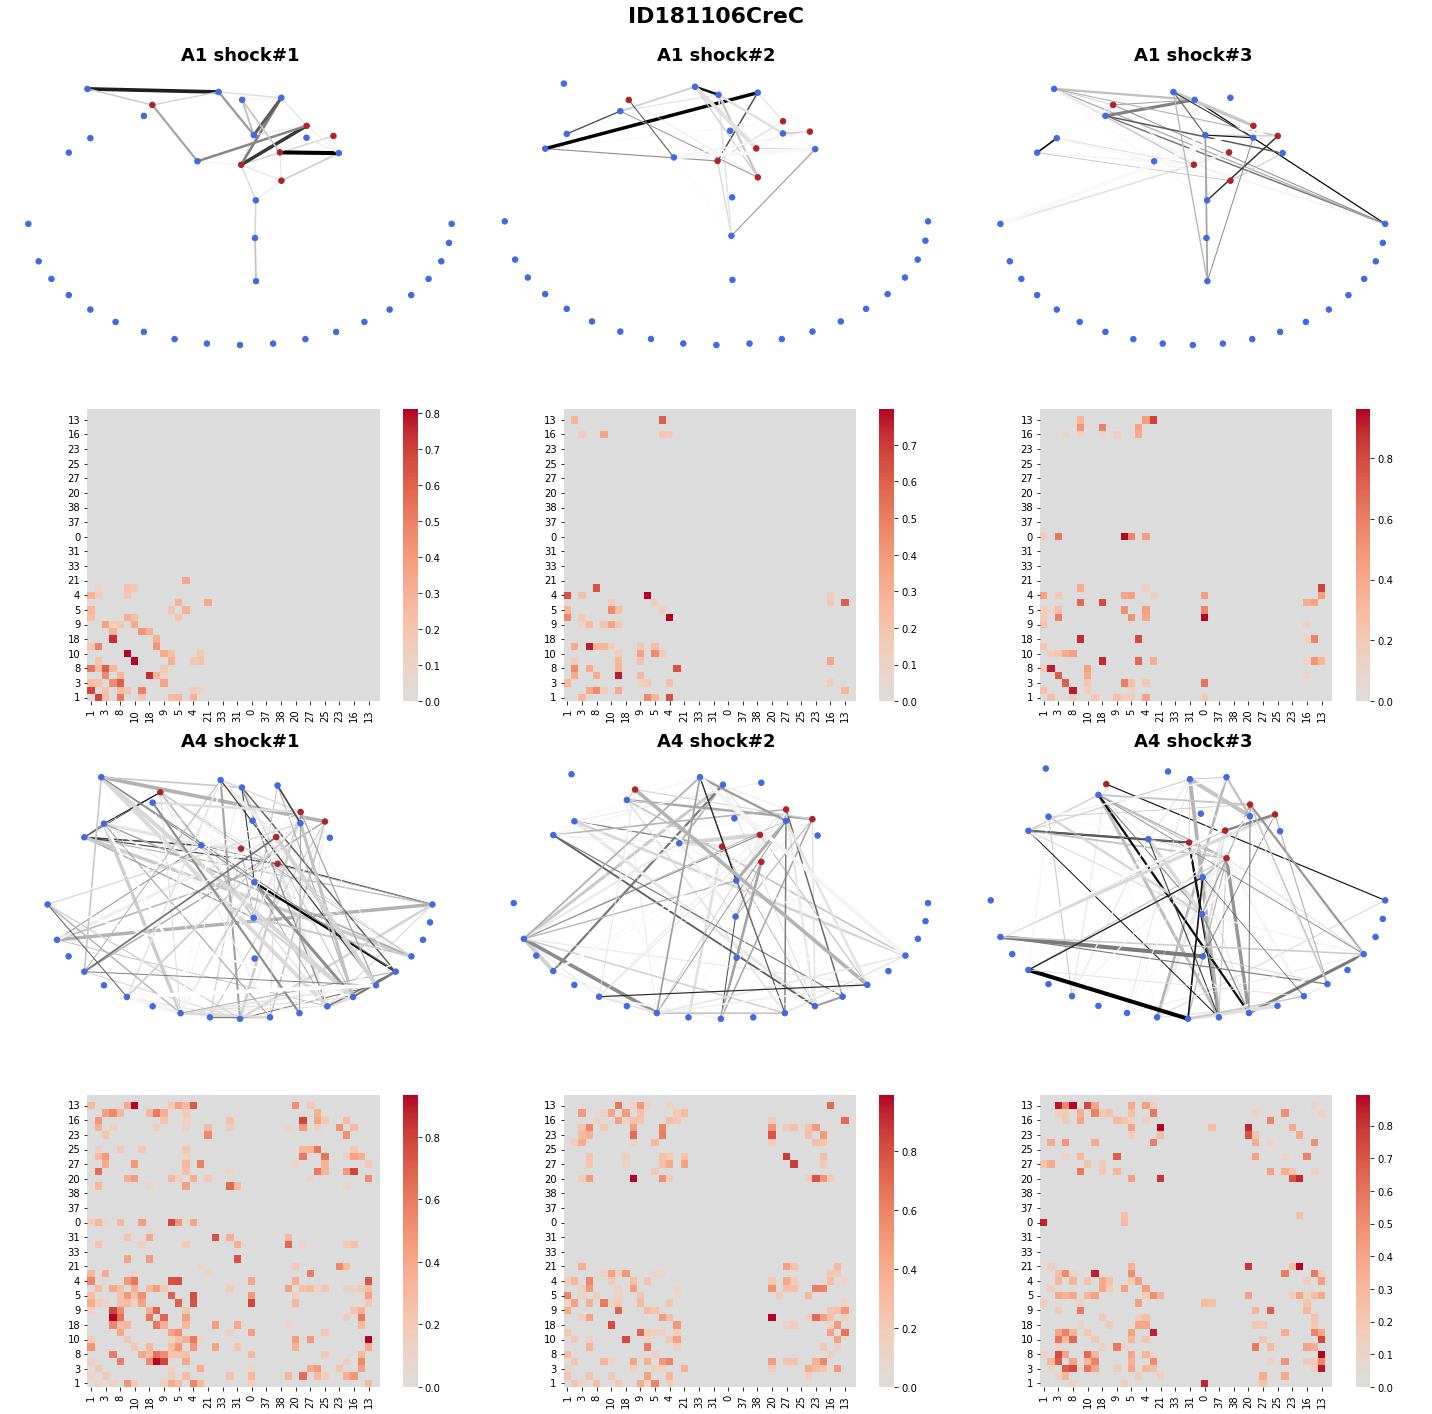

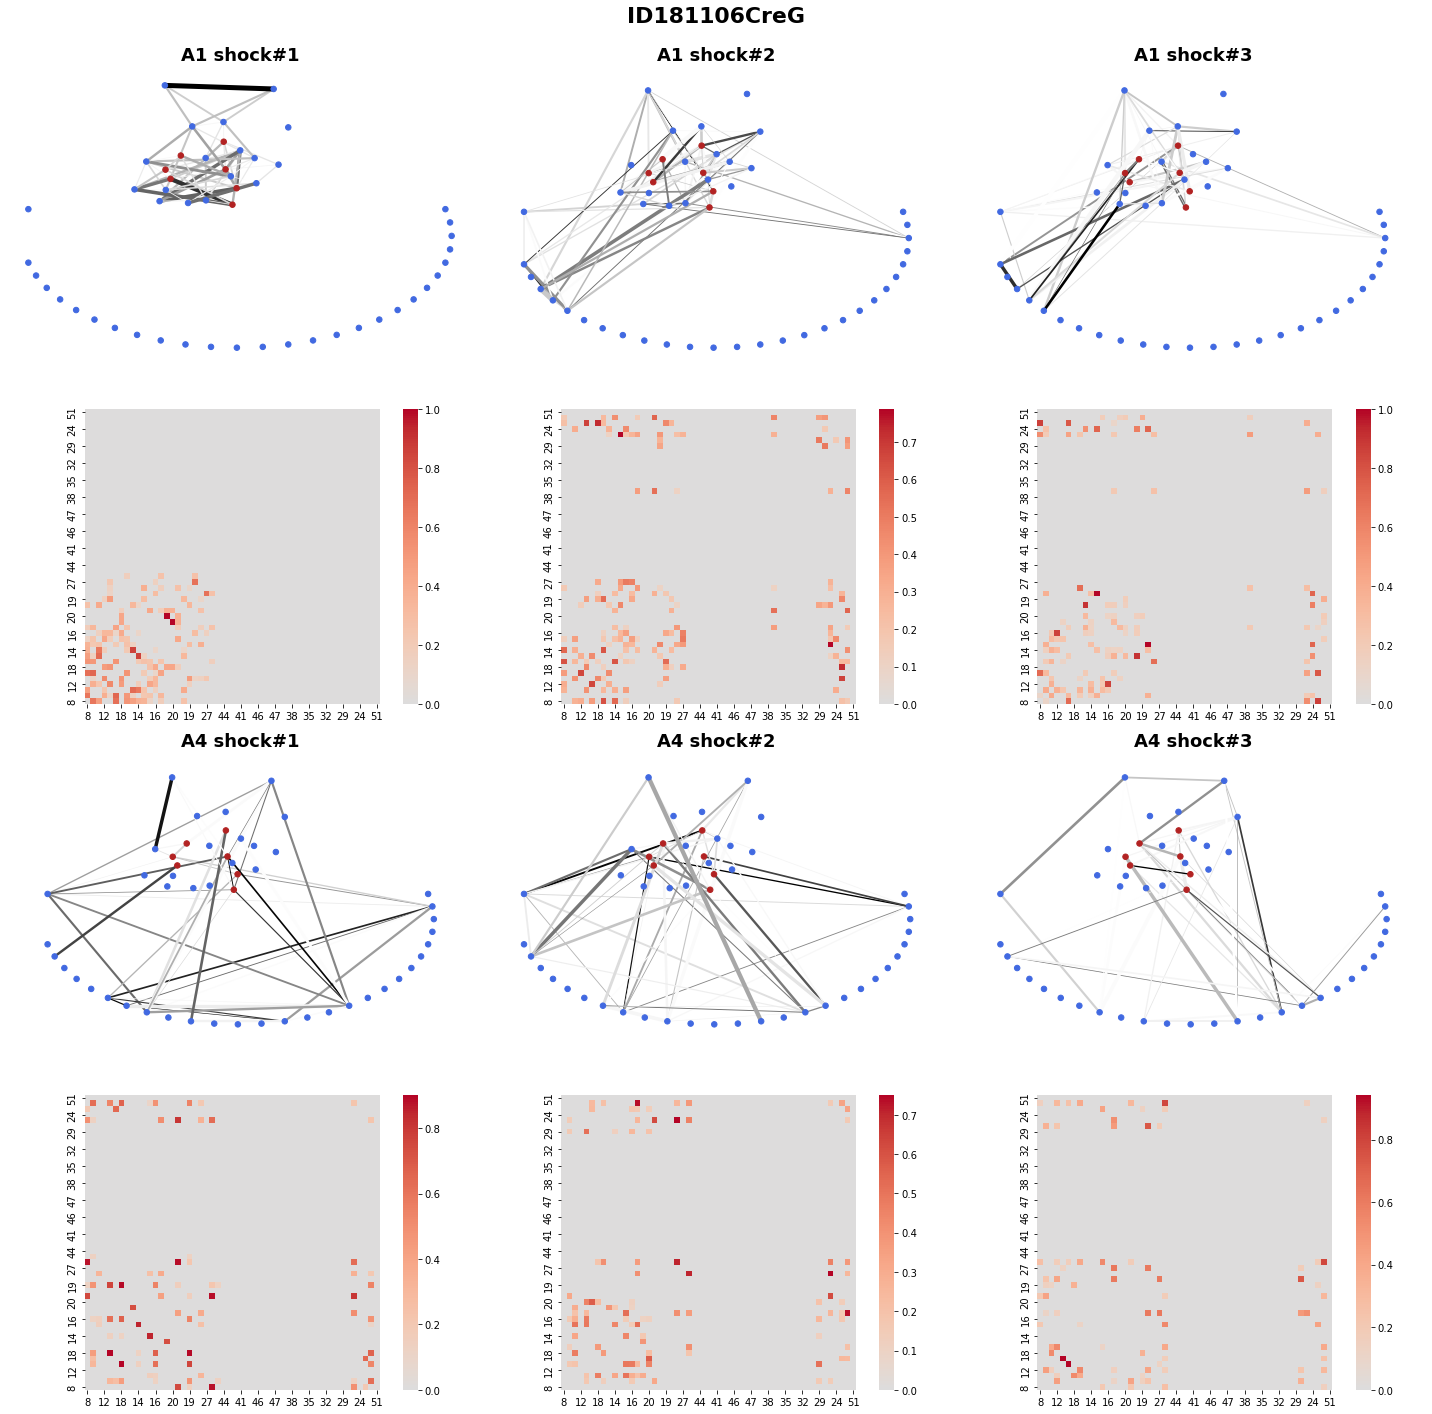

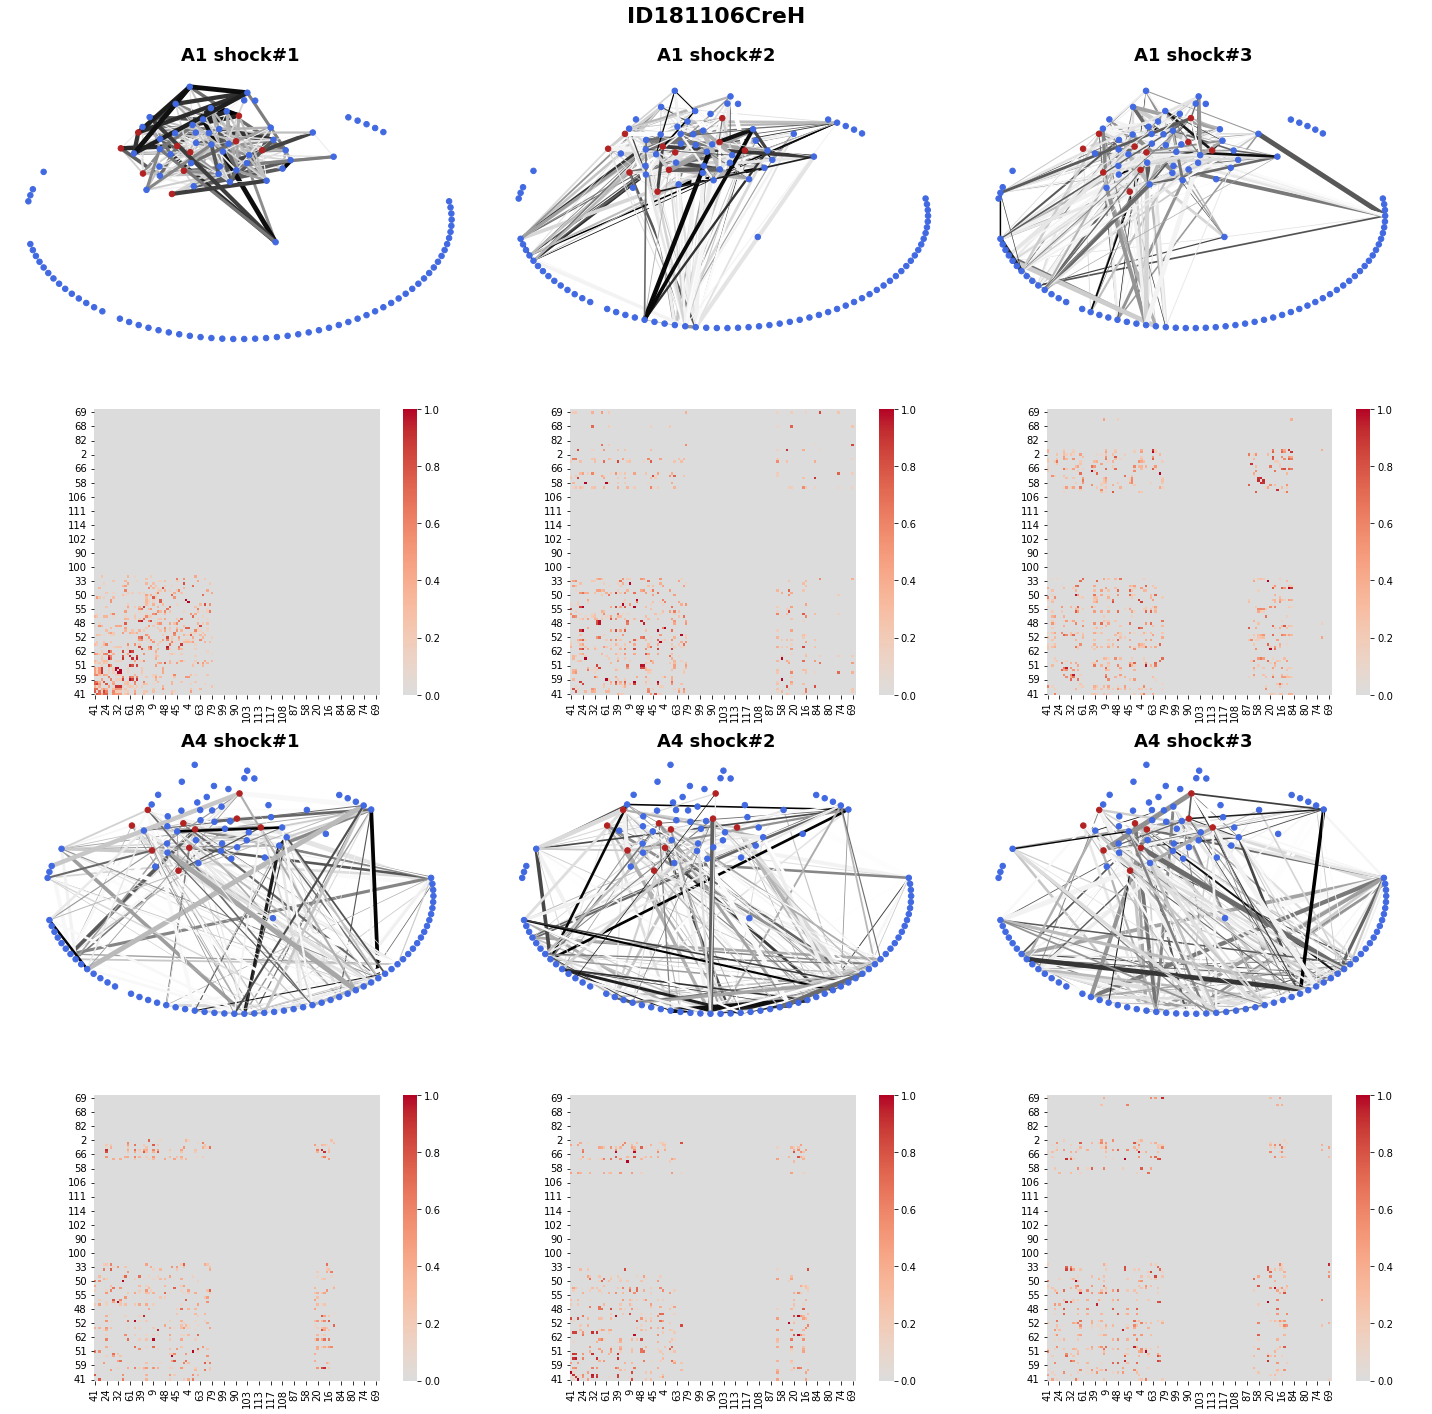

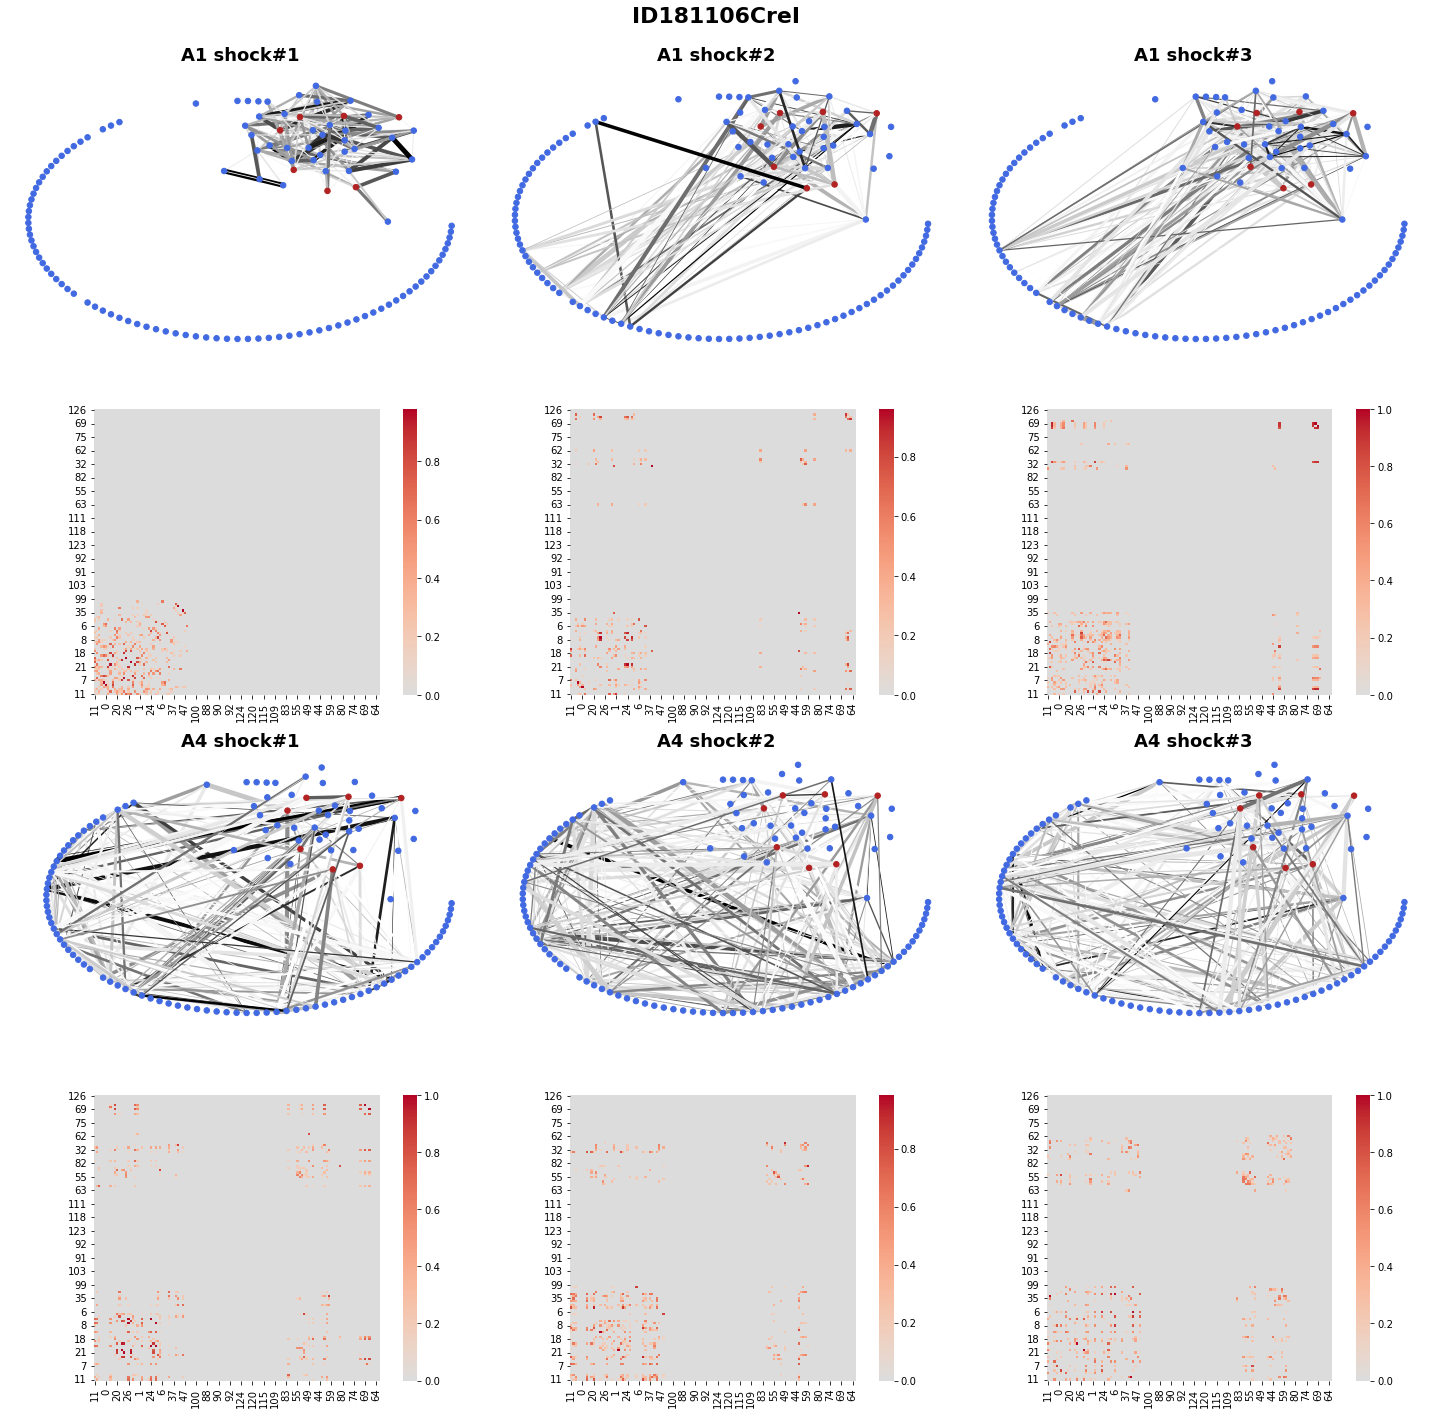

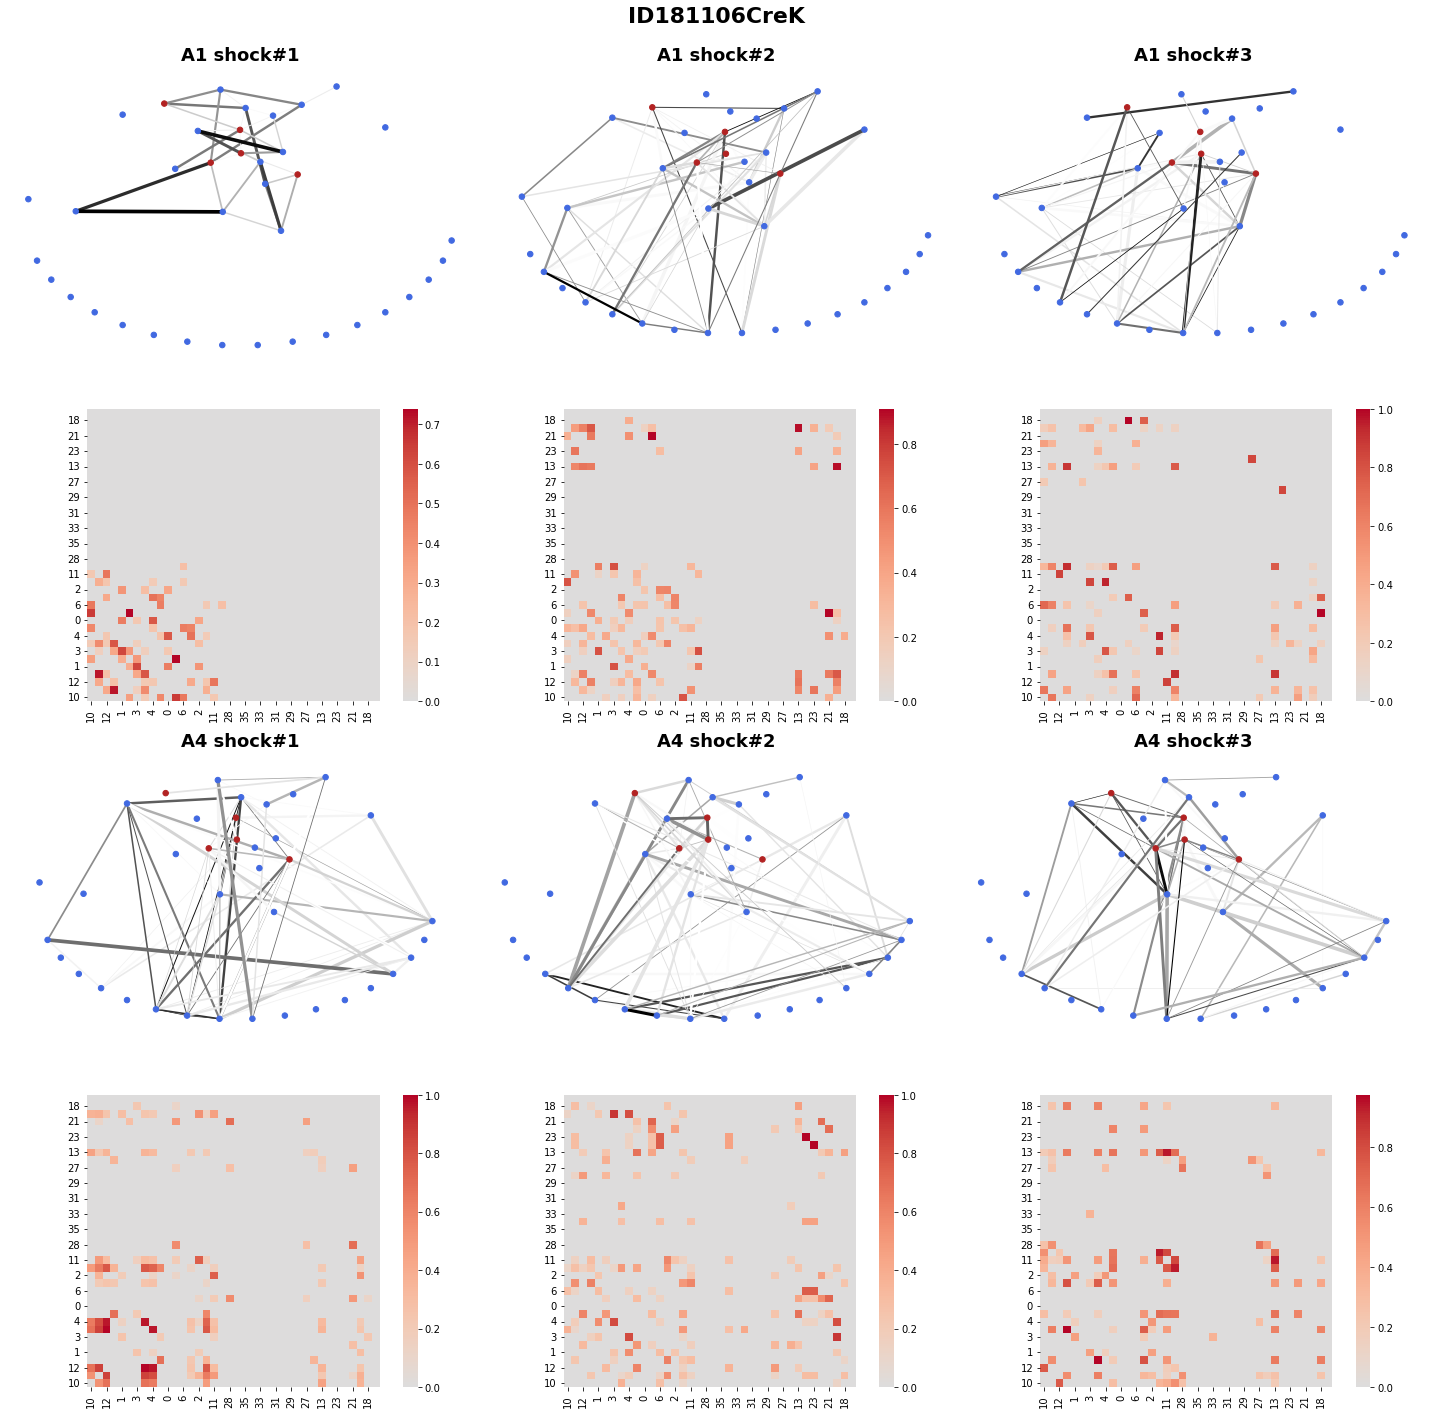

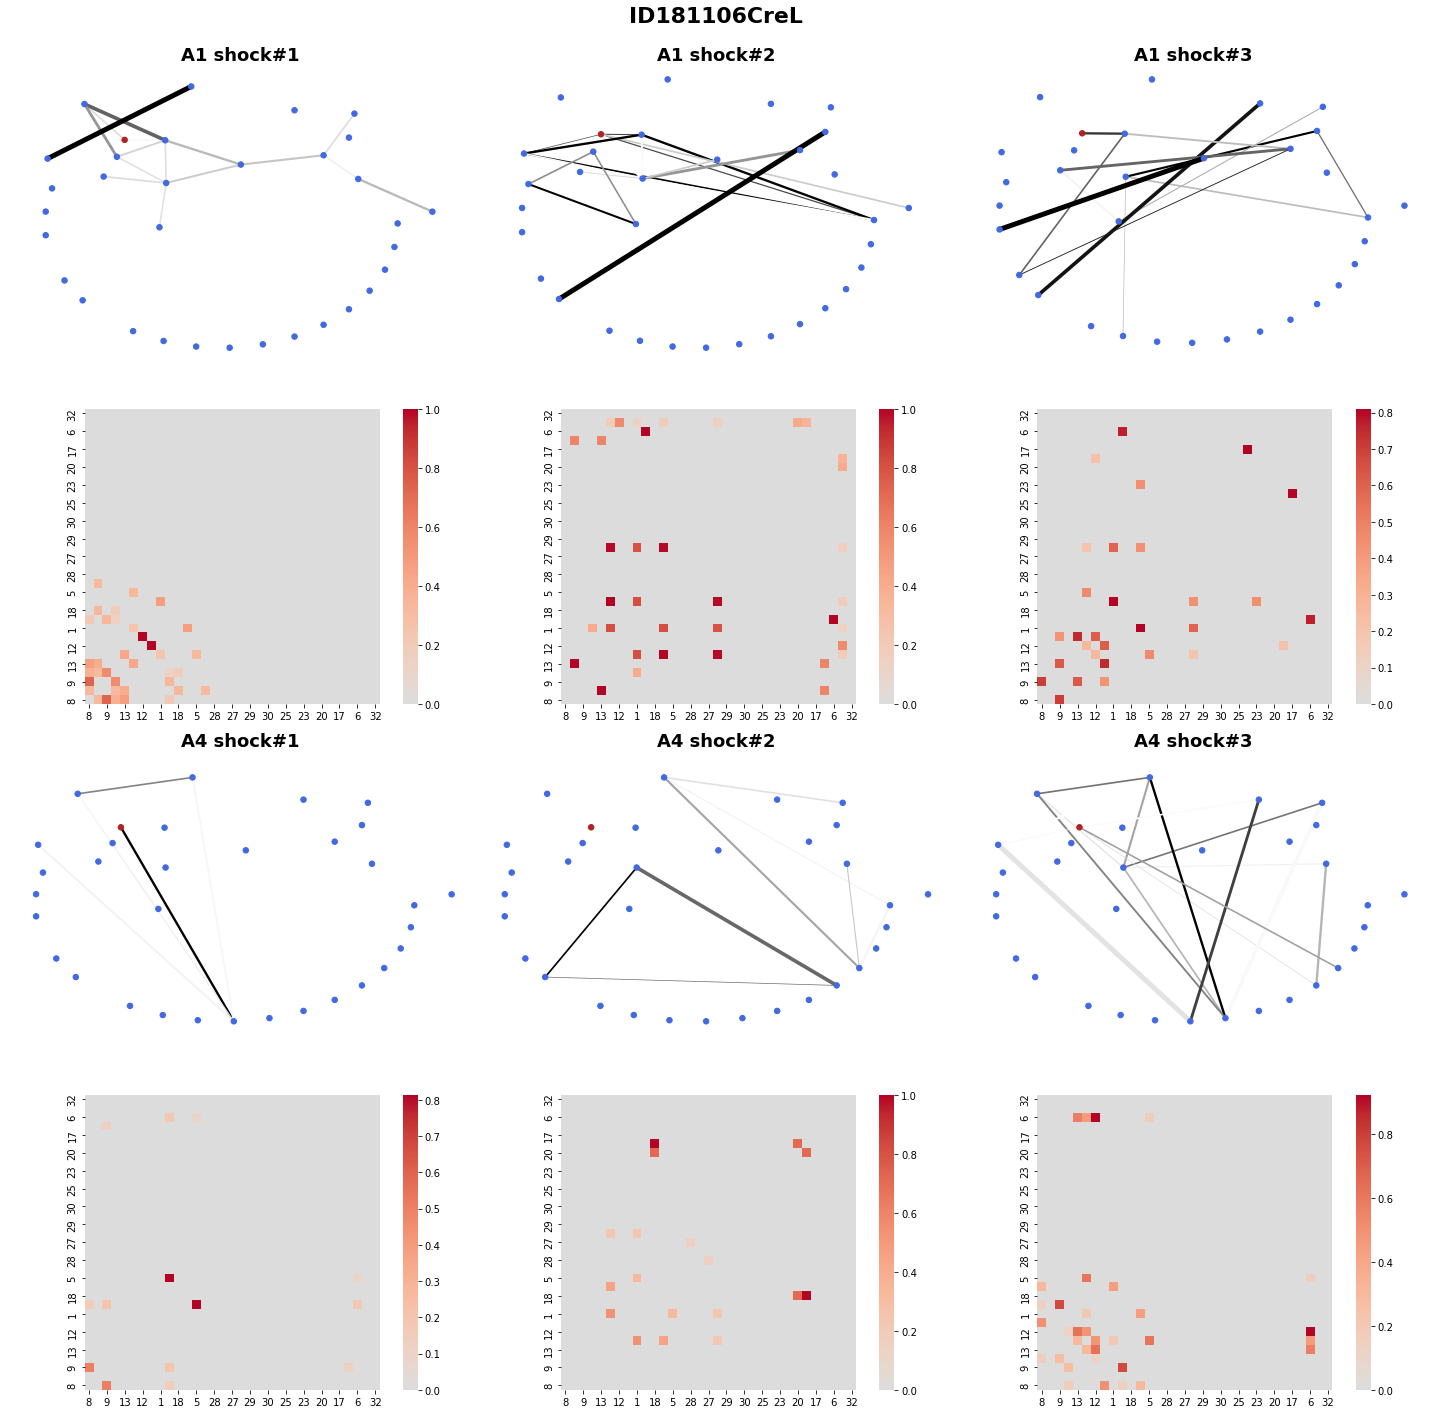

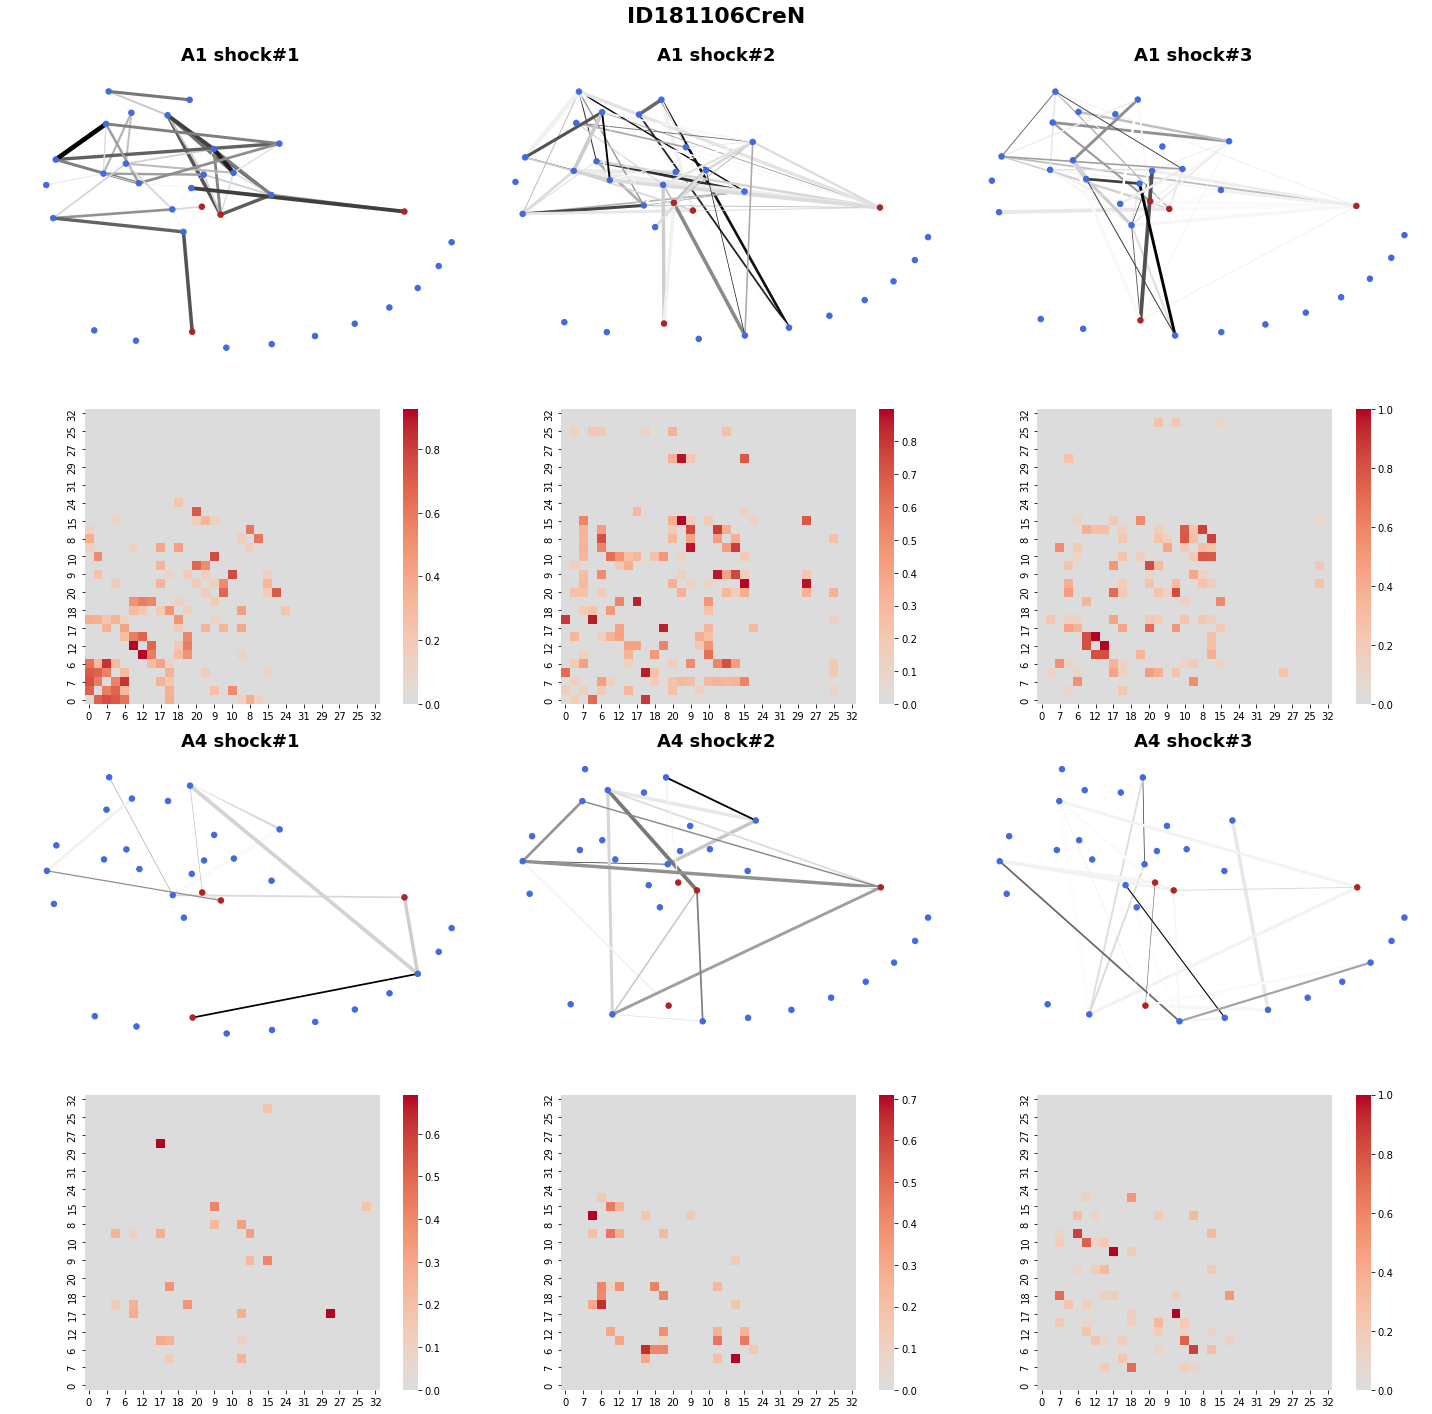

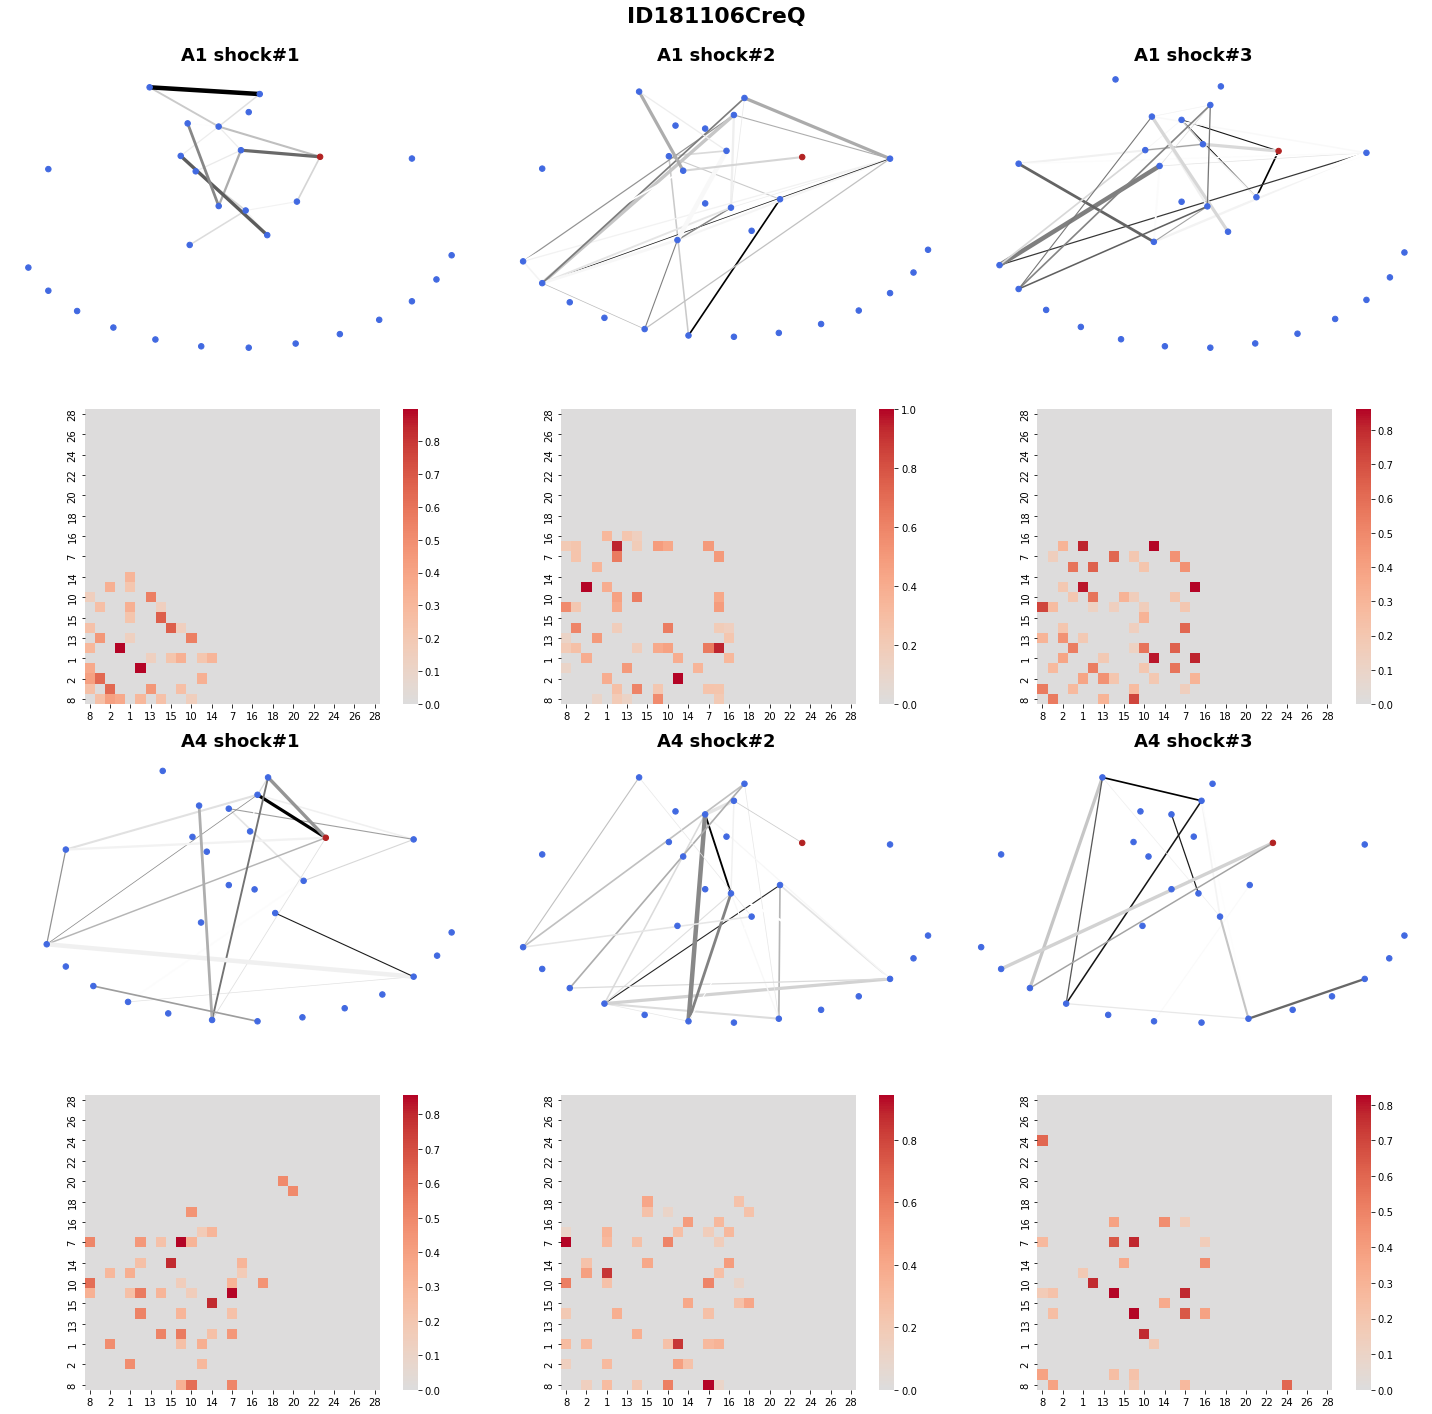

In [5]:
%%time

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    shock_cells = engram_shock_cells[animal_name]
    
    def is_shock_cell(cell_name):
        return cell_name in shock_cells
    
    print('##### context: A1post')
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
    a1_engram_matrix = a1_matrix.loc[:, a1_csv.engram_cells()]
    
    a1_generator = CofiringGraphGenerator(a1_engram_matrix, is_shock_cell)
    a1_1_graph = a1_generator.run(80, 100)
    a1_2_graph = a1_generator.run(980, 1000)
    a1_3_graph = a1_generator.run(1880, 1900)
    
    calc_features(animal_name, 'A1_1', a1_1_graph, df)
    calc_features(animal_name, 'A1_2', a1_2_graph, df)
    calc_features(animal_name, 'A1_3', a1_3_graph, df)
    
    print('##### context: A4post')
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = MatrixOptimizer(a4_csv.data_frame).divide_sd()
    a4_engram_matrix = a4_matrix.loc[:, a4_csv.engram_cells()]
    
    a4_generator = CofiringGraphGenerator(a4_engram_matrix, is_shock_cell)
    a4_1_graph = a4_generator.run(80, 100)
    a4_2_graph = a4_generator.run(980, 1000)
    a4_3_graph = a4_generator.run(1880, 1900)
    
    calc_features(animal_name, 'A4_1', a4_1_graph, df)
    calc_features(animal_name, 'A4_2', a4_2_graph, df)
    calc_features(animal_name, 'A4_3', a4_3_graph, df)
    
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20))
        
    pos = nx.kamada_kawai_layout(a1_1_graph)
    node_size = 30.0
    adjacency_matrixes = []
    
    a1_1_edges, a1_1_weights = zip(*nx.get_edge_attributes(a1_1_graph, 'weight').items())
    a1_1_node_colors = [options["color"] for cell_name, options in a1_1_graph.nodes(data=True)]
    nx.draw(a1_1_graph, pos, node_size=node_size, node_color=a1_1_node_colors, edgelist=a1_1_edges, edge_color=a1_1_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[0][0])
    axes[0][0].set_title('A1 shock#1', fontsize=18, fontweight='bold')
    
    a1_1_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_1_graph).toarray())
    adjacency_matrixes.append(a1_1_adjacency_matrix.copy(deep=True))
    ordered_high_weight_index = a1_1_adjacency_matrix.sum().sort_values(ascending=False).index
    a1_1_adjacency_matrix = a1_1_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    
    ax = sns.heatmap(a1_1_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][0])
    ax.invert_yaxis()
    
    a1_2_edges, a1_2_weights = zip(*nx.get_edge_attributes(a1_2_graph, 'weight').items())
    a1_2_node_colors = [options["color"] for cell_name, options in a1_2_graph.nodes(data=True)]
    nx.draw(a1_2_graph, pos, node_size=node_size, node_color=a1_2_node_colors, edgelist=a1_2_edges, edge_color=a1_2_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[0][1])
    axes[0][1].set_title('A1 shock#2', fontsize=18, fontweight='bold')
    
    a1_2_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_2_graph).toarray())
    adjacency_matrixes.append(a1_2_adjacency_matrix.copy(deep=True))
    a1_2_adjacency_matrix = a1_2_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    
    ax = sns.heatmap(a1_2_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][1])
    ax.invert_yaxis()
    
    a1_3_edges, a1_3_weights = zip(*nx.get_edge_attributes(a1_3_graph, 'weight').items())
    a1_3_node_colors = [options["color"] for cell_name, options in a1_3_graph.nodes(data=True)]
    nx.draw(a1_3_graph, pos, node_size=node_size, node_color=a1_3_node_colors, edgelist=a1_3_edges, edge_color=a1_3_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[0][2])
    axes[0][2].set_title('A1 shock#3', fontsize=18, fontweight='bold')
    
    a1_3_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a1_3_graph).toarray())
    adjacency_matrixes.append(a1_3_adjacency_matrix.copy(deep=True))
    a1_3_adjacency_matrix = a1_3_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    
    ax = sns.heatmap(a1_3_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[1][2])
    ax.invert_yaxis()
    
    a4_1_edges, a4_1_weights = zip(*nx.get_edge_attributes(a4_1_graph, 'weight').items())
    a4_1_node_colors = [options["color"] for cell_name, options in a4_1_graph.nodes(data=True)]
    nx.draw(a4_1_graph, pos, node_size=node_size, node_color=a4_1_node_colors, edgelist=a4_1_edges, edge_color=a4_1_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[2][0])
    axes[2][0].set_title('A4 shock#1', fontsize=18, fontweight='bold')
    
    a4_1_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_1_graph).toarray())
    adjacency_matrixes.append(a4_1_adjacency_matrix.copy(deep=True))
    a4_1_adjacency_matrix = a4_1_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    
    ax = sns.heatmap(a4_1_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][0])
    ax.invert_yaxis()
    
    a4_2_edges, a4_2_weights = zip(*nx.get_edge_attributes(a4_2_graph, 'weight').items())
    a4_2_node_colors = [options["color"] for cell_name, options in a4_2_graph.nodes(data=True)]
    nx.draw(a4_2_graph, pos, node_size=node_size, node_color=a4_2_node_colors, edgelist=a4_2_edges, edge_color=a4_2_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[2][1])
    axes[2][1].set_title('A4 shock#2', fontsize=18, fontweight='bold')
    
    a4_2_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_2_graph).toarray())
    adjacency_matrixes.append(a4_2_adjacency_matrix.copy(deep=True))
    a4_2_adjacency_matrix = a4_2_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    
    ax = sns.heatmap(a4_2_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][1])
    ax.invert_yaxis()
    
    a4_3_edges, a4_3_weights = zip(*nx.get_edge_attributes(a4_3_graph, 'weight').items())
    a4_3_node_colors = [options["color"] for cell_name, options in a4_3_graph.nodes(data=True)]
    nx.draw(a4_3_graph, pos, node_size=node_size, node_color=a4_3_node_colors, edgelist=a4_3_edges, edge_color=a4_3_weights, width=(np.array(a1_1_weights) * 5), edge_cmap=plt.cm.Greys, ax=axes[2][2])
    axes[2][2].set_title('A4 shock#3', fontsize=18, fontweight='bold')
    
    a4_3_adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(a4_3_graph).toarray())
    adjacency_matrixes.append(a4_3_adjacency_matrix.copy(deep=True))
    a4_3_adjacency_matrix = a4_3_adjacency_matrix.reindex(index=ordered_high_weight_index, columns=ordered_high_weight_index, copy=True)
    ax = sns.heatmap(a4_3_adjacency_matrix, square=True, cmap='coolwarm', center=0.0, ax=axes[3][2])
    ax.invert_yaxis()
    
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle(animal_name, fontsize=22, fontweight='bold')
    fig.show()
    
df

/tmp/ipykernel_92/3111130534.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_92/3111130534.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_92/3111130534.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
/tmp/ipykernel_92/3111130534.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_92/3111130534.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_92/3111130534.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


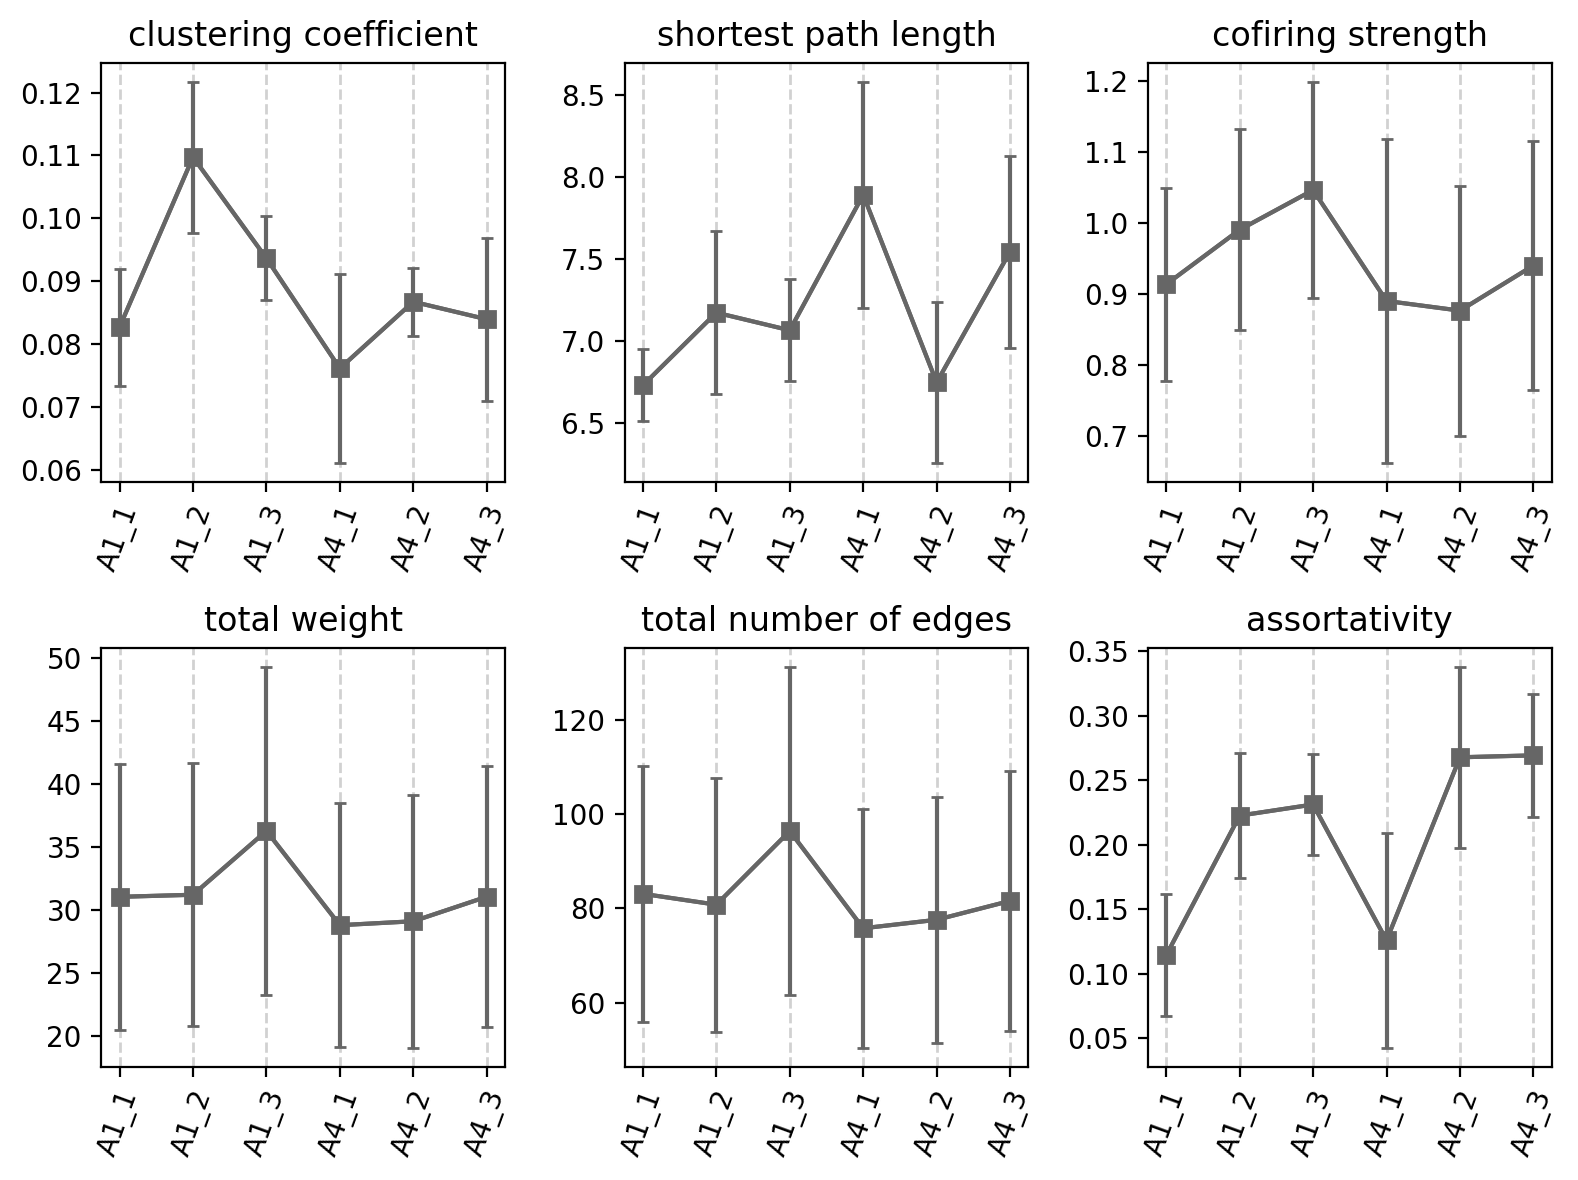

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
summary_df = df
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('total weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('total number of edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()